In [1]:
import tensorflow as tf
from tensorflow import keras
print("TensorFlow version:", tf.__version__)

2022-11-05 00:14:16.009441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


TensorFlow version: 2.4.1


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns

In [3]:
from os.path import join
import os

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
data_folder = "../../data/preprocessed/"

In [6]:
X = pd.read_pickle(join(data_folder, "X.pk"))
y = pd.read_pickle(join(data_folder, "Y.pk"))
X_mat = X.values
y_vec = y.values.flatten()
y_vec[y_vec == 1] = 0
y_vec[y_vec == 2] = 1
scaler = StandardScaler()
scaler.fit(X_mat)
X_mat = scaler.transform(X_mat)

x_train, x_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size=0.2, random_state=123)


In [7]:
x_train.shape

(56568, 262)

In [8]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(x_train.shape[1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

2022-11-05 00:14:30.469389: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-05 00:14:30.472139: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-05 00:14:30.496038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro P4000 computeCapability: 6.1
coreClock: 1.48GHz coreCount: 14 deviceMemorySize: 7.92GiB deviceMemoryBandwidth: 226.62GiB/s
2022-11-05 00:14:30.496061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-05 00:14:30.499043: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-11-05 00:14:30.499096: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-11-05

In [9]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [10]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                4208      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.predict(x_train[:10])

2022-11-05 00:14:42.784689: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-05 00:14:42.802887: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2022-11-05 00:14:42.845590: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


array([[0.42841727],
       [0.6480823 ],
       [0.78400797],
       [0.5143804 ],
       [0.58969724],
       [0.7841426 ],
       [0.69994813],
       [0.38035205],
       [0.64336497],
       [0.49463966]], dtype=float32)

In [12]:
results = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6897


In [13]:
pos = np.sum(y_vec==1)
neg = np.sum(y_vec==0)

In [14]:
initial_bias = np.log([pos/neg])
initial_bias



array([2.6028264])

In [15]:
model = make_model(output_bias=initial_bias)
model.predict(x_train[:10])

array([[0.7736323 ],
       [0.9175887 ],
       [0.91447496],
       [0.72575706],
       [0.7616525 ],
       [0.79255754],
       [0.8654802 ],
       [0.8978722 ],
       [0.95354974],
       [0.9178205 ]], dtype=float32)

In [16]:
results = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.2981


In [17]:
initial_weights = os.path.join("weigths", 'initial_weights')
model.save_weights(initial_weights)

In [18]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(x_test, y_test), 
    verbose=0)

In [19]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(x_test, y_test), 
    verbose=0)

In [20]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

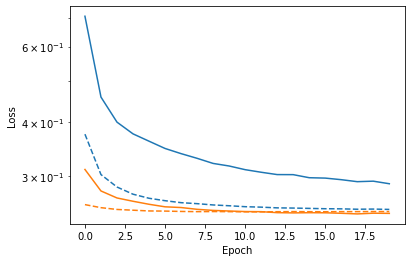

In [21]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [22]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(x_test, y_test))

Epoch 1/100
28/28 [==============================] - 2s 28ms/step - loss: 0.3363 - tp: 40811.2414 - fp: 2984.4138 - tn: 91.7586 - fn: 851.4483 - accuracy: 0.9142 - precision: 0.9319 - recall: 0.9794 - auc: 0.5256 - prc: 0.9331 - val_loss: 0.2574 - val_tp: 13165.0000 - val_fp: 975.0000 - val_tn: 0.0000e+00 - val_fn: 3.0000 - val_accuracy: 0.9308 - val_precision: 0.9310 - val_recall: 0.9998 - val_auc: 0.5484 - val_prc: 0.9391
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 0.2735 - tp: 28370.1379 - fp: 2059.4138 - tn: 28.9310 - fn: 137.3793 - accuracy: 0.9285 - precision: 0.9330 - recall: 0.9948 - auc: 0.5394 - prc: 0.9390 - val_loss: 0.2528 - val_tp: 13164.0000 - val_fp: 974.0000 - val_tn: 1.0000 - val_fn: 4.0000 - val_accuracy: 0.9308 - val_precision: 0.9311 - val_recall: 0.9997 - val_auc: 0.5631 - val_prc: 0.9418
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.2670 - tp: 28410.5517 - fp: 2081.1379 - tn: 20.5172 - fn: 83.6552 - accura

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(x_test, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  # sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))
  print(cm)

In [ ]:
baseline_results = model.evaluate(x_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3)
])

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

In [ ]:
tf.nn.softmax(predictions).numpy()

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# sample_weight=tf.constant([2, 2, 0.1])
loss_fn(y_train[:1], predictions, sample_weight=tf.constant([2, 2, 0.1])).numpy()

In [ ]:
model.compile(optimizer='adam',
              # loss=loss_fn,
              loss=loss_fn,
              metrics=['categorical_accuracy'])

In [ ]:
class_weight = {0:1.2,
               1:1.2,
               2:0.1}
model.fit(x_train, y_train, epochs=50, class_weight=class_weight)

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)



In [ ]:
ids2test = [0,76,77,83,90,1036, 1055, 3168,5558,14140]

# 83,    90, 3168 !!! 1
# 1036,  1055  5558, !!! 0
# 14140 0 76,  77 !!! 2

In [ ]:
logits = model.predict(x_test[ids2test,:])
results = tf.math.argmax(tf.nn.softmax(logits).numpy(), axis =1)
print(results.numpy())
print(y_test[ids2test])

In [ ]:
m = tf.keras.metrics.Recall()
m.update_state(tf.nn.softmax(logits).numpy(), y_test[ids2test])
m.result().numpy()